In [1]:
import numpy as np
import cv2
import reid.datasets
import matplotlib.pyplot as plt
%matplotlib inline
import os.path as osp

from reid.utils.data.dataset import _pluck
from reid.datasets import CUHK03

In [3]:
OUTPUT_SHAPE = (H, W, _) = (128, 48, 3)

In [ ]:
!ls ./datasets

## Substitui o método download para utilizar apenas as imagens rotuladas (labeled) em vez de labeled + detected, pois na implementação original há o dobro de imagens e isso é incorreto

In [4]:
def download(self):
    if self._check_integrity():
        print("Files already downloaded and verified")
        return

    import h5py
    import hashlib
    from scipy.misc import imsave
    from zipfile import ZipFile
    
    from reid.utils.osutils import mkdir_if_missing
    from reid.utils.serialization import write_json

    raw_dir = osp.join(self.root, 'raw')
    mkdir_if_missing(raw_dir)

    # Download the raw zip file
    fpath = osp.join(raw_dir, 'cuhk03_release.zip')
    if osp.isfile(fpath) and \
      hashlib.md5(open(fpath, 'rb').read()).hexdigest() == self.md5:
        print("Using downloaded file: " + fpath)
    else:
        raise RuntimeError("Please download the dataset manually from {} "
                           "to {}".format(self.url, fpath))

    # Extract the file
    exdir = osp.join(raw_dir, 'cuhk03_release')
    if not osp.isdir(exdir):
        print("Extracting zip file")
        with ZipFile(fpath) as z:
            z.extractall(path=raw_dir)

    # Format
    images_dir = osp.join(self.root, 'images')
    mkdir_if_missing(images_dir)
    matdata = h5py.File(osp.join(exdir, 'cuhk-03.mat'), 'r')

    def deref(ref):
        return matdata[ref][:].T

    def dump_(refs, pid, cam, fnames):
        for ref in refs:
            img = deref(ref)
            if img.size == 0 or img.ndim < 2: break
            fname = '{:08d}_{:02d}_{:04d}.jpg'.format(pid, cam, len(fnames))
            imsave(osp.join(images_dir, fname), img)
            fnames.append(fname)

    identities = []
    for labeled in matdata['labeled'][0]:
        labeled = deref(labeled)
        for i in range(labeled.shape[0]):
            pid = len(identities)
            images = [[], []]
            dump_(labeled[i, :5], pid, 0, images[0])
            dump_(labeled[i, 5:], pid, 1, images[1])
            identities.append(images)
            
    # Save meta information into a json file
    meta = {'name': 'cuhk03', 'shot': 'multiple', 'num_cameras': 2,
            'identities': identities}
    write_json(meta, osp.join(self.root, 'meta.json'))

    # Save training and test splits
    splits = []
    view_counts = [deref(ref).shape[0] for ref in matdata['labeled'][0]]
    vid_offsets = np.r_[0, np.cumsum(view_counts)]
    for ref in matdata['testsets'][0]:
        test_info = deref(ref).astype(np.int32)
        test_pids = sorted(
            [int(vid_offsets[i-1] + j - 1) for i, j in test_info])
        trainval_pids = list(set(range(vid_offsets[-1])) - set(test_pids))
        split = {'trainval': trainval_pids,
                 'query': test_pids,
                 'gallery': test_pids}
        splits.append(split)
    write_json(splits, osp.join(self.root, 'splits.json'))

In [5]:
CUHK03.download = download

In [6]:
dataset = CUHK03('./datasets/cuhk03', download=False)

CUHK03 dataset loaded
  subset   | # ids | # images
  ---------------------------
  train    |  1267 |    12165
  val      |   100 |      966
  trainval |  1367 |    13131
  query    |   100 |      965
  gallery  |   100 |      965


In [7]:
dataset.trainval[:30]

[('00001324_00_0000.jpg', 0, 0),
 ('00001324_00_0001.jpg', 0, 0),
 ('00001324_00_0002.jpg', 0, 0),
 ('00001324_00_0003.jpg', 0, 0),
 ('00001324_00_0004.jpg', 0, 0),
 ('00001324_01_0000.jpg', 0, 1),
 ('00001324_01_0001.jpg', 0, 1),
 ('00001324_01_0002.jpg', 0, 1),
 ('00001324_01_0003.jpg', 0, 1),
 ('00001118_00_0000.jpg', 1, 0),
 ('00001118_00_0001.jpg', 1, 0),
 ('00001118_00_0002.jpg', 1, 0),
 ('00001118_00_0003.jpg', 1, 0),
 ('00001118_00_0004.jpg', 1, 0),
 ('00001118_01_0000.jpg', 1, 1),
 ('00001118_01_0001.jpg', 1, 1),
 ('00001118_01_0002.jpg', 1, 1),
 ('00001118_01_0003.jpg', 1, 1),
 ('00001118_01_0004.jpg', 1, 1),
 ('00000044_00_0000.jpg', 2, 0),
 ('00000044_00_0001.jpg', 2, 0),
 ('00000044_00_0002.jpg', 2, 0),
 ('00000044_00_0003.jpg', 2, 0),
 ('00000044_00_0004.jpg', 2, 0),
 ('00000044_01_0000.jpg', 2, 1),
 ('00000044_01_0001.jpg', 2, 1),
 ('00000044_01_0002.jpg', 2, 1),
 ('00000044_01_0003.jpg', 2, 1),
 ('00000044_01_0004.jpg', 2, 1),
 ('00000002_00_0000.jpg', 3, 0)]

In [8]:
print(dataset.split)
print(len(dataset.split['trainval']))

{'query': [3, 17, 29, 60, 64, 82, 97, 104, 119, 127, 141, 143, 172, 191, 196, 219, 230, 235, 251, 253, 265, 273, 293, 299, 300, 312, 324, 330, 335, 345, 359, 379, 400, 403, 413, 415, 417, 422, 461, 472, 499, 534, 542, 544, 565, 579, 587, 599, 600, 623, 629, 659, 684, 708, 740, 748, 751, 756, 786, 817, 832, 838, 861, 870, 874, 887, 902, 935, 937, 941, 952, 953, 968, 988, 989, 1045, 1053, 1064, 1109, 1112, 1128, 1141, 1175, 1176, 1190, 1204, 1229, 1231, 1236, 1239, 1249, 1252, 1274, 1281, 1284, 1295, 1299, 1325, 1352, 1354], 'gallery': [3, 17, 29, 60, 64, 82, 97, 104, 119, 127, 141, 143, 172, 191, 196, 219, 230, 235, 251, 253, 265, 273, 293, 299, 300, 312, 324, 330, 335, 345, 359, 379, 400, 403, 413, 415, 417, 422, 461, 472, 499, 534, 542, 544, 565, 579, 587, 599, 600, 623, 629, 659, 684, 708, 740, 748, 751, 756, 786, 817, 832, 838, 861, 870, 874, 887, 902, 935, 937, 941, 952, 953, 968, 988, 989, 1045, 1053, 1064, 1109, 1112, 1128, 1141, 1175, 1176, 1190, 1204, 1229, 1231, 1236, 1239, 12

In [13]:
dataset.train[:10]

[('00000000_00_0000.jpg', 0, 0),
 ('00000000_00_0001.jpg', 0, 0),
 ('00000000_00_0002.jpg', 0, 0),
 ('00000000_00_0003.jpg', 0, 0),
 ('00000000_00_0004.jpg', 0, 0),
 ('00000000_01_0000.jpg', 0, 1),
 ('00000000_01_0001.jpg', 0, 1),
 ('00000000_01_0002.jpg', 0, 1),
 ('00000000_01_0003.jpg', 0, 1),
 ('00000000_01_0004.jpg', 0, 1)]

In [10]:
dataset.val[:10]

[('00000001_00_0000.jpg', 0, 0),
 ('00000001_00_0001.jpg', 0, 0),
 ('00000001_00_0002.jpg', 0, 0),
 ('00000001_00_0003.jpg', 0, 0),
 ('00000001_00_0004.jpg', 0, 0),
 ('00000001_01_0000.jpg', 0, 1),
 ('00000001_01_0001.jpg', 0, 1),
 ('00000001_01_0002.jpg', 0, 1),
 ('00000001_01_0003.jpg', 0, 1),
 ('00000001_01_0004.jpg', 0, 1)]

In [ ]:
train_ids = set([x[1] for x in dataset.trainval])
val_ids = set([x[1] for x in dataset.val])

In [9]:
dataset.meta['identities'][150]

[['00000150_00_0000.jpg', '00000150_00_0001.jpg', '00000150_00_0002.jpg'],
 ['00000150_01_0000.jpg',
  '00000150_01_0001.jpg',
  '00000150_01_0002.jpg',
  '00000150_01_0003.jpg',
  '00000150_01_0004.jpg']]

In [10]:
dataset.meta['identities'][:10], len(dataset.meta['identities'])

([[['00000000_00_0000.jpg',
    '00000000_00_0001.jpg',
    '00000000_00_0002.jpg',
    '00000000_00_0003.jpg',
    '00000000_00_0004.jpg'],
   ['00000000_01_0000.jpg',
    '00000000_01_0001.jpg',
    '00000000_01_0002.jpg',
    '00000000_01_0003.jpg',
    '00000000_01_0004.jpg']],
  [['00000001_00_0000.jpg',
    '00000001_00_0001.jpg',
    '00000001_00_0002.jpg',
    '00000001_00_0003.jpg',
    '00000001_00_0004.jpg'],
   ['00000001_01_0000.jpg',
    '00000001_01_0001.jpg',
    '00000001_01_0002.jpg',
    '00000001_01_0003.jpg',
    '00000001_01_0004.jpg']],
  [['00000002_00_0000.jpg',
    '00000002_00_0001.jpg',
    '00000002_00_0002.jpg',
    '00000002_00_0003.jpg'],
   ['00000002_01_0000.jpg',
    '00000002_01_0001.jpg',
    '00000002_01_0002.jpg',
    '00000002_01_0003.jpg',
    '00000002_01_0004.jpg']],
  [['00000003_00_0000.jpg',
    '00000003_00_0001.jpg',
    '00000003_00_0002.jpg',
    '00000003_00_0003.jpg',
    '00000003_00_0004.jpg'],
   ['00000003_01_0000.jpg', '00000003_

# Extraindo o dataset

## Treinamento

In [23]:
 def load_img_and_resize(fpath, out_shape=(128, 48, 3)):
    """ Carrega a imagem, transforma BGR->RGB e redimensiona para out_shape. """
    img = cv2.cvtColor(cv2.imread(fpath),cv2.COLOR_BGR2RGB)
    if img.shape != out_shape:
        Ho, Wo, _ = out_shape
        img = cv2.resize(img, (Wo, Ho), interpolation=cv2.INTER_AREA)
    # Adiciona uma dimensão para poder concatenar as imagens
    return img.reshape((1,) + out_shape)

### Carrega as imagens e as labels (person IDs)

In [37]:
X_train = []
y_train = []
for (fname, pid, cam_id) in dataset.train:
    fpath = osp.join(dataset.root, 'images', fname)
    img = load_img_and_resize(fpath, out_shape=OUTPUT_SHAPE)
    X_train.append(img)
    y_train.append(pid)
    
X_train = np.concatenate(X_train, axis=0)
y_train = np.array(y_train)

In [38]:
print(len(X_train), X_train[0].shape, X_train[0].dtype, X_train[0].min(), X_train[0].max())

12165 (128, 48, 3) uint8 2 255


In [39]:
print(len(y_train), y_train.shape, y_train.dtype, y_train.min(), y_train.max())

12165 (12165,) int64 0 1266


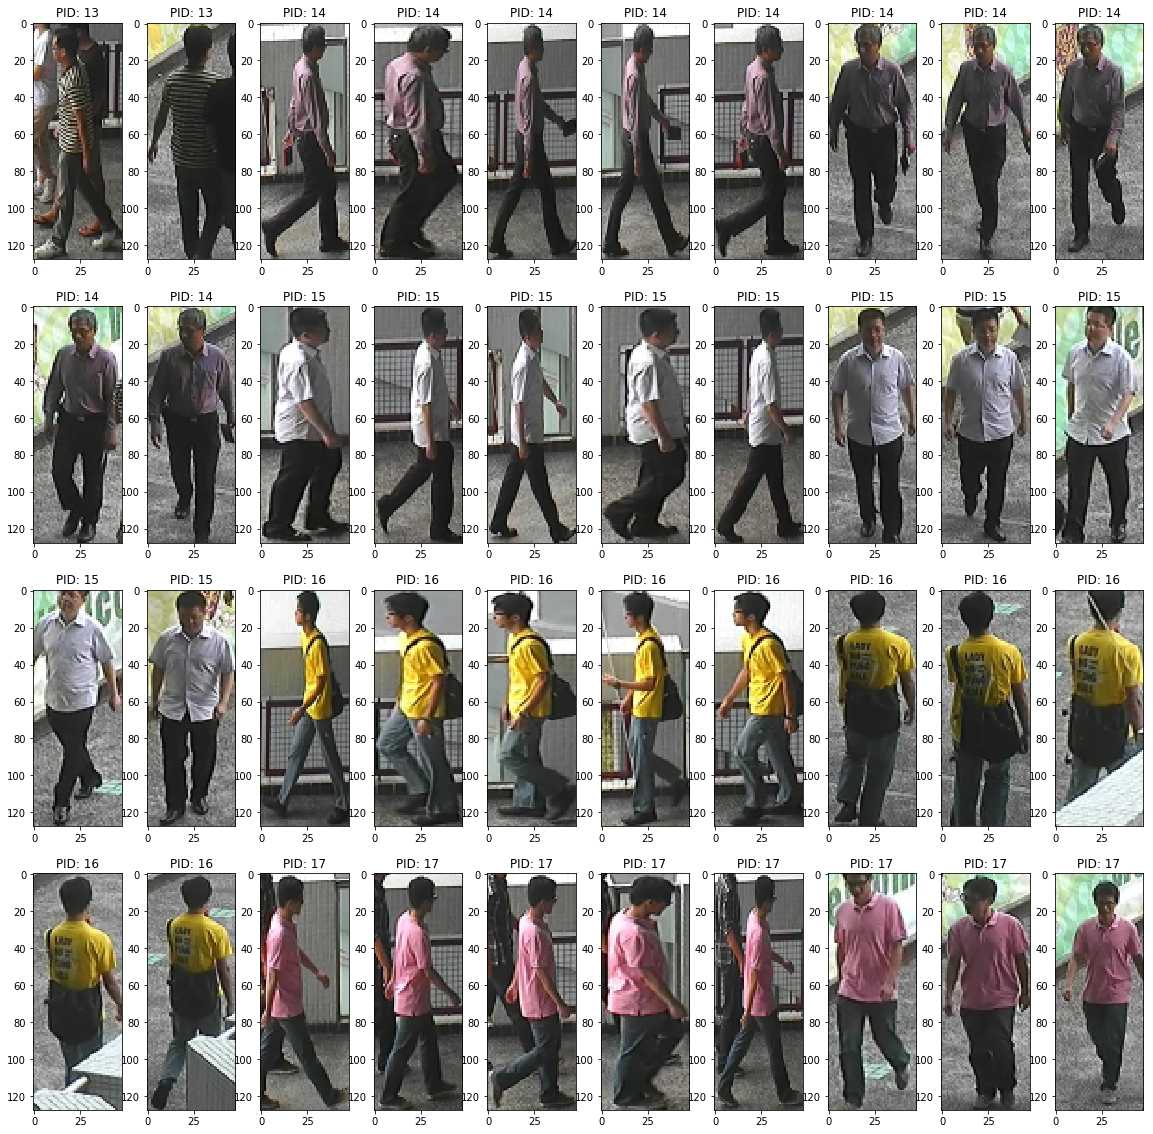

In [40]:
offset = 130
plt.figure(figsize=(20, 20))
for i in range(40):
    plt.subplot(4,10,i+1)
    img = X_train[offset+i]
    plt.imshow(img)
    plt.title('PID: {}'.format(y_train[offset+i]))

## Validação

In [57]:
# Retorna tuplas (filepath, person_id, cam_id)
for d in dataset.val[:20]: print(d)


('00000001_00_0000.jpg', 0, 0)
('00000001_00_0001.jpg', 0, 0)
('00000001_00_0002.jpg', 0, 0)
('00000001_00_0003.jpg', 0, 0)
('00000001_00_0004.jpg', 0, 0)
('00000001_01_0000.jpg', 0, 1)
('00000001_01_0001.jpg', 0, 1)
('00000001_01_0002.jpg', 0, 1)
('00000001_01_0003.jpg', 0, 1)
('00000001_01_0004.jpg', 0, 1)
('00000028_00_0000.jpg', 1, 0)
('00000028_00_0001.jpg', 1, 0)
('00000028_00_0002.jpg', 1, 0)
('00000028_00_0003.jpg', 1, 0)
('00000028_00_0004.jpg', 1, 0)
('00000028_01_0000.jpg', 1, 1)
('00000028_01_0001.jpg', 1, 1)
('00000028_01_0002.jpg', 1, 1)
('00000066_00_0000.jpg', 2, 0)
('00000066_00_0001.jpg', 2, 0)


In [58]:
X_val = []
y_val = []
val_cam_ids = []
for (fname, pid, cam_id) in dataset.val:
    fpath = osp.join(dataset.root, 'images', fname)
    img = load_img_and_resize(fpath, out_shape=OUTPUT_SHAPE)
    X_val.append(img)
    y_val.append(pid)
    val_cam_ids.append(cam_id)
    
X_val = np.concatenate(X_val, axis=0)
y_val = np.array(y_val)
val_cam_ids = np.array(val_cam_ids)

In [42]:
print(len(X_val), X_val[0].shape, X_val[0].dtype, X_val[0].min(), X_val[0].max())

966 (128, 48, 3) uint8 5 253


In [44]:
print(len(y_val), y_val.shape, y_val.dtype, y_val.min(), y_val.max())

966 (966,) int64 0 99


In [59]:
print(len(val_cam_ids), val_cam_ids.shape, val_cam_ids.dtype, val_cam_ids.min(), val_cam_ids.max())

966 (966,) int64 0 1


In [60]:
print('Número de PIDs diferentes em y_val: ', len(np.unique(y_val)))

Número de PIDs diferentes em y_val:  100


# Query + Gallery

In [73]:
for d in dataset.query: print(d)

('00000003_00_0000.jpg', 3, 0)
('00000003_00_0001.jpg', 3, 0)
('00000003_00_0002.jpg', 3, 0)
('00000003_00_0003.jpg', 3, 0)
('00000003_00_0004.jpg', 3, 0)
('00000003_01_0000.jpg', 3, 1)
('00000003_01_0001.jpg', 3, 1)
('00000003_01_0002.jpg', 3, 1)
('00000017_00_0000.jpg', 17, 0)
('00000017_00_0001.jpg', 17, 0)
('00000017_00_0002.jpg', 17, 0)
('00000017_00_0003.jpg', 17, 0)
('00000017_00_0004.jpg', 17, 0)
('00000017_01_0000.jpg', 17, 1)
('00000017_01_0001.jpg', 17, 1)
('00000017_01_0002.jpg', 17, 1)
('00000017_01_0003.jpg', 17, 1)
('00000017_01_0004.jpg', 17, 1)
('00000029_00_0000.jpg', 29, 0)
('00000029_00_0001.jpg', 29, 0)
('00000029_00_0002.jpg', 29, 0)
('00000029_00_0003.jpg', 29, 0)
('00000029_00_0004.jpg', 29, 0)
('00000029_01_0000.jpg', 29, 1)
('00000029_01_0001.jpg', 29, 1)
('00000029_01_0002.jpg', 29, 1)
('00000029_01_0003.jpg', 29, 1)
('00000029_01_0004.jpg', 29, 1)
('00000060_00_0000.jpg', 60, 0)
('00000060_00_0001.jpg', 60, 0)
('00000060_00_0002.jpg', 60, 0)
('00000060_00_00

In [61]:
print(dataset.split['query'] == dataset.split['gallery'])

True


In [62]:
print(dataset.split['query'])

[3, 17, 29, 60, 64, 82, 97, 104, 119, 127, 141, 143, 172, 191, 196, 219, 230, 235, 251, 253, 265, 273, 293, 299, 300, 312, 324, 330, 335, 345, 359, 379, 400, 403, 413, 415, 417, 422, 461, 472, 499, 534, 542, 544, 565, 579, 587, 599, 600, 623, 629, 659, 684, 708, 740, 748, 751, 756, 786, 817, 832, 838, 861, 870, 874, 887, 902, 935, 937, 941, 952, 953, 968, 988, 989, 1045, 1053, 1064, 1109, 1112, 1128, 1141, 1175, 1176, 1190, 1204, 1229, 1231, 1236, 1239, 1249, 1252, 1274, 1281, 1284, 1295, 1299, 1325, 1352, 1354]


In [63]:
query_ids = dataset.split['query']
print('Quantidade de IDs: {}'.format(len(query_ids)))
print(query_ids[:10], '...', query_ids[-10:])

Quantidade de IDs: 100
[3, 17, 29, 60, 64, 82, 97, 104, 119, 127] ... [1249, 1252, 1274, 1281, 1284, 1295, 1299, 1325, 1352, 1354]


In [64]:
X_query = []
y_query = []
query_cam_ids = []

for (fname, pid, cam_id) in query_data:
    fpath = osp.join(dataset.root, 'images', fname)
    img = load_img_and_resize(fpath, out_shape=OUTPUT_SHAPE)
    X_query.append(img)
    y_query.append(pid)
    query_cam_ids.append(cam_id)


X_query = np.concatenate(X_query, axis=0)
y_query = np.array(y_query)
query_cam_ids = np.array(query_cam_ids)

In [65]:
print(len(X_query), X_query[0].shape, X_query[0].dtype, X_query[0].min(), X_query[0].max())

965 (128, 48, 3) uint8 4 255


In [69]:
print(len(query_cam_ids), query_cam_ids.shape, query_cam_ids.dtype, query_cam_ids.min(), query_cam_ids.max())

965 (965,) int64 0 1


In [68]:
print(query_cam_ids[:15], query_cam_ids[-15:])

[0 0 0 0 0 1 1 1 0 0 0 0 0 1 1] [0 0 0 0 1 1 1 1 1 0 1 1 1 1 1]


In [81]:
print('IDs distintos para Query e Gallery: ', len(np.unique(y_query)))
print(np.unique(y_query))

IDs distintos para Query e Gallery:  100
[   3   17   29   60   64   82   97  104  119  127  141  143  172  191  196
  219  230  235  251  253  265  273  293  299  300  312  324  330  335  345
  359  379  400  403  413  415  417  422  461  472  499  534  542  544  565
  579  587  599  600  623  629  659  684  708  740  748  751  756  786  817
  832  838  861  870  874  887  902  935  937  941  952  953  968  988  989
 1045 1053 1064 1109 1112 1128 1141 1175 1176 1190 1204 1229 1231 1236 1239
 1249 1252 1274 1281 1284 1295 1299 1325 1352 1354]


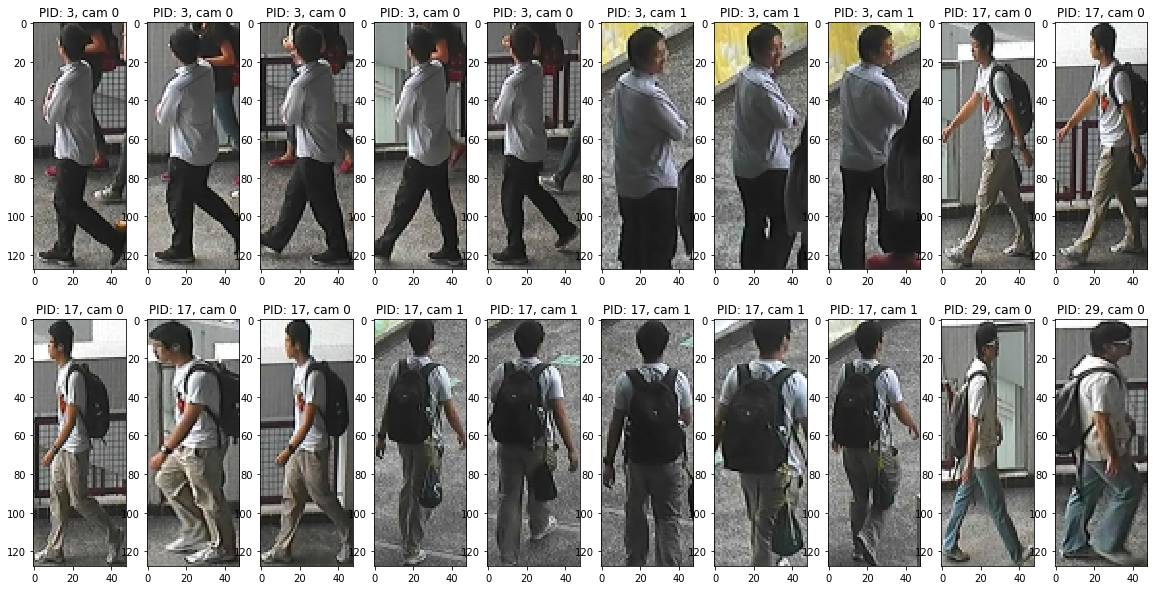

In [72]:
plt.figure(figsize=(20, 10))
for i in range(20):
    plt.subplot(2,10,i+1)
    img = X_query[i]
    plt.imshow(img)
    plt.title('PID: {}, cam {}'.format(y_query[i], query_cam_ids[i]))

# Gallery: são os mesmos IDs de Query



# Salva o arquivo npz

In [82]:
np.savez('./datasets/cuhk03_train_correct', X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, val_cam_ids=val_cam_ids)

In [57]:
np.savez('./datasets/cuhk03_test_correct', X_querygal=X_query, y_querygal=y_query, cam_ids=query_cam_ids)